In [164]:
import netCDF4 as nc
import glob
import numpy as np
fs=glob.glob("output/subset_*.nc")
fs=sorted(fs)
y_lastbin=[]
x_data=[]
y_data=[]
p_type_data=[]
n_seq_data=[]
#print(fs)
y_nonz=[[]for k in range(44+18)]
x_nonz=[[]for k in range(44+18)]
for f in fs:
    with nc.Dataset(f) as fh:
        vars=fh.variables.keys()
        z_meas=fh.variables['z_meas'][:]
        p_type=fh.variables['p_type'][:]
        bin_nodes=fh.variables['bin_nodes'][:]
        sfc_bin=fh.variables['sfc_bin'][:]
        p_rate_cmb=fh.variables['p_rate_cmb'][:]
        dm=fh.variables['dm'][:]
        bin_zero_deg=fh.variables['bin_zero_deg'][:]
        bin_storm_top=fh.variables['bin_storm_top'][:]
        z_meas2=np.log10(0.5*10**(z_meas[:,::2]/10)+0.5*10**(z_meas[:,1::2]/10)+1e-9)*10
        z_meas2[z_meas2<0]=0
        for i,z_meas_1d in enumerate(z_meas2):
            #if p_type[i]==3:
            #    continue
            itop=bin_storm_top[i]//2
            x_1d=[]
            y_1d=[]
            i_valid=0
            for k1 in range(bin_nodes[i,2]-44,bin_nodes[i,2]+18): 
                if k1<itop:
                    x_1d.append([0.0,0.0])
                    y_1d.append([0.0,0.0])
                    i_valid+=1
                else:
                    if k1<bin_nodes[i,-1]:
                        if dm[i,k1]>0:
                            y_nonz[k1-(bin_nodes[i,2]-44)].append([np.log10(1+p_rate_cmb[i,k1]/0.1),dm[i,k1]])
                            x_nonz[k1-(bin_nodes[i,2]-44)].append([z_meas_1d[k1,0],z_meas_1d[k1,1]])
                        x_1d.append([z_meas_1d[k1,0],z_meas_1d[k1,1]])
                        y_1d.append([np.log10(1+p_rate_cmb[i,k1]/0.1),dm[i,k1]])
                        #print(y_1d[-1])
                        if k1==bin_nodes[i,-1]-1:
                            y_lastbin.append([np.log10(1+p_rate_cmb[i,k1]/0.1),dm[i,k1]])
                            if dm[i,k1]<0.1 and dm[i,k1-1]>0:
                                y_1d[-1]=y_1d[-2]
                                y_lastbin[-1]=y_1d[-2]
                        i_valid+=1
                    else:
                        x_1d.append([0.0,0.0])
                        y_1d.append([0.0,0.0])
            #print(itop,bin_nodes[i])
            #print(x_1d)
            #break
            #print(p_rate_cmb[i,:bin_nodes[i,-1]].min())
            n_seq_data.append(i_valid)
            x_data.append(x_1d)
            y_data.append(y_1d)
            p_type_data.append(p_type[i])
        #break

#vars='z_meas', 'p_type', 'bin_nodes', 'sfc_bin', 'p_rate_cmb', 'dm', 'bin_zero_deg', 'bin_storm_top'


In [165]:
y_m=[]
y_s=[]
x_m=[]
x_s=[]
for k in range(44+16):
    y_m.append(np.array(y_nonz[k]).mean(axis=0))
    y_s.append(np.array(y_nonz[k]).std(axis=0)) 
    x_m.append(np.array(x_nonz[k]).mean(axis=0))
    x_s.append(np.array(x_nonz[k]).std(axis=0))


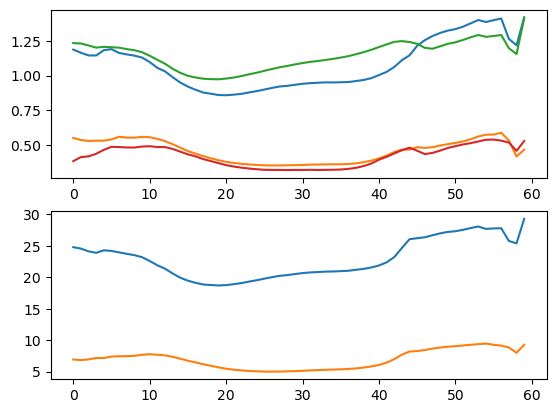

In [166]:
plt.subplot(2,1,1)
plt.plot(np.array(y_m)[:,0])
plt.plot(np.array(y_s)[:,0])
plt.plot(np.array(y_m)[:,1])
plt.plot(np.array(y_s)[:,1])
plt.subplot(2,1,2)
plt.plot(np.array(x_m)[:,0])
plt.plot(np.array(x_s)[:,0])


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_6317/2951783668.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(((y_data)/y_data_s)[:,:,0].std(axis=0))


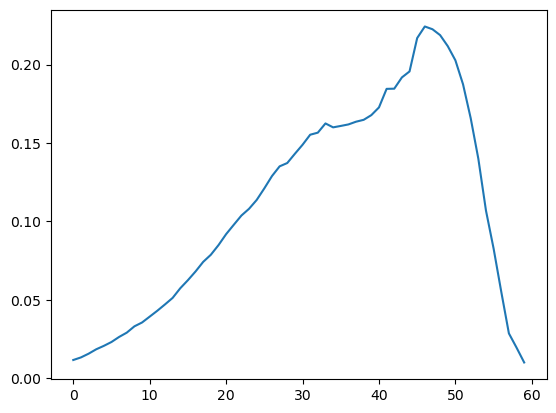

In [145]:
y_data=np.array(y_data)
x_data=np.array(x_data)
#plt.plot(y_data[:,:,0].mean(axis=0))
#plt.plot(y_data[:,:,0].max(axis=0))
y_data_m=y_data.mean()
y_data_s=y_data.max(axis=0)
plt.plot(((y_data)/y_data_s)[:,:,0].std(axis=0))

[81 65 69 71 82]


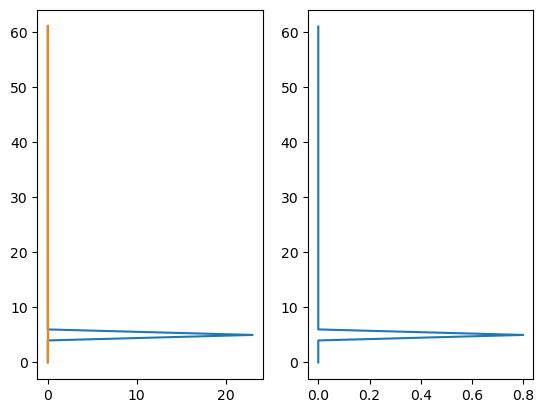

In [56]:
x_1d=np.array(x_1d)
y_1d=np.array(y_1d)
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot(x_1d[::-1,0],np.arange(44+18))
plt.plot(x_1d[::-1,1],np.arange(44+18))
print(bin_nodes[i])
plt.subplot(122)
plt.plot(y_1d[::-1,1],np.arange(44+18))

In [3]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class LSTMPackedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPackedModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Final output layer
    
    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply the output layer to the LSTM output
        output = self.fc(output)
        
        return output

# Example usage:
# Assume input is a padded batch with variable sequence lengths
batch_size = 3
seq_lengths = torch.tensor([4, 2, 1])  # Variable lengths of the sequences
input_size = 10
hidden_size = 20
num_layers = 2
output_size = 5

model = LSTMPackedModel(input_size, hidden_size, num_layers, output_size)

# Create a batch of padded inputs with variable lengths
padded_input = torch.randn(batch_size, seq_lengths.max(), input_size)

# Forward pass
output = model(padded_input, seq_lengths)


In [203]:
x_data_n=np.array(x_data)
y_data_n=np.array(y_data)
x_data_n=(x_data_n-np.mean(x_data_n,axis=0))/6
y_data_n=(y_data_n-np.mean(y_data_n,axis=0))/0.4
x_data_t=torch.tensor(x_data,dtype=torch.float32)
y_data_t=torch.tensor(y_data,dtype=torch.float32)
n_seq_data_t=torch.tensor(n_seq_data,dtype=torch.int32)
p_type_data=np.array(p_type_data)
a=np.nonzero(p_type_data==2)[0]

x_data_conv=x_data_t[a]
y_data_conv=y_data_t[a]
n_seq_data_conv=n_seq_data_t[a]

a=np.nonzero(p_type_data==1)[0]
x_data_strat=x_data_t[a]
y_data_strat=y_data_t[a]
n_seq_data_strat=n_seq_data_t[a]

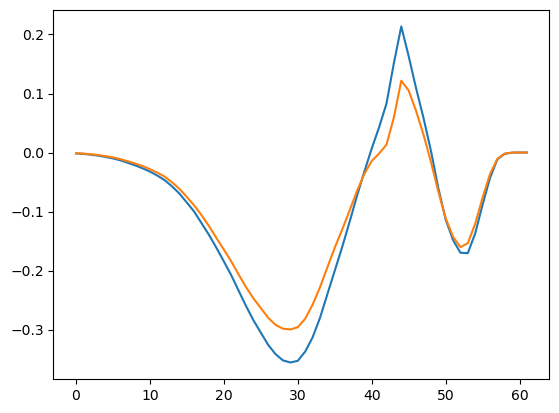

In [204]:
x_data=np.array(x_data)
plt.plot(x_data_n[a][:,:,0].mean(axis=0))
plt.plot(x_data_n[a][:,:,1].mean(axis=0))

In [215]:
a=np.nonzero(p_type_data==2)[0]
print(n_seq_data)
x_data_strat_n=torch.tensor(x_data_n[a],dtype=torch.float32)
y_data_strat_n=torch.tensor(y_data_n[a],dtype=torch.float32)
n_seq_data_strat=torch.tensor(np.array(n_seq_data)[a],dtype=torch.int32)

strat_data=torch.utils.data.TensorDataset(x_data_strat_n[::10,:,:],y_data_strat_n[::10,:,:],n_seq_data_strat[::10])
strat_loader=torch.utils.data.DataLoader(strat_data,batch_size=32,shuffle=True)



[38, 37, 38, 38, 38, 38, 38, 37, 36, 38, 38, 37, 36, 39, 39, 38, 38, 37, 39, 38, 38, 38, 38, 37, 39, 39, 39, 37, 38, 37, 37, 40, 39, 39, 39, 37, 39, 37, 37, 40, 40, 39, 39, 39, 38, 38, 37, 38, 40, 39, 39, 39, 39, 38, 39, 38, 38, 41, 40, 41, 39, 39, 38, 39, 38, 37, 37, 38, 42, 42, 41, 40, 40, 41, 40, 39, 39, 39, 37, 37, 37, 38, 42, 42, 42, 40, 41, 41, 41, 40, 39, 39, 38, 37, 37, 38, 36, 41, 41, 41, 40, 41, 40, 40, 40, 39, 39, 39, 37, 38, 37, 42, 42, 42, 42, 41, 41, 41, 38, 39, 38, 38, 37, 40, 42, 42, 42, 41, 41, 40, 40, 39, 38, 38, 39, 37, 38, 37, 42, 40, 41, 41, 41, 41, 41, 42, 40, 39, 39, 38, 38, 37, 37, 38, 42, 42, 40, 41, 41, 41, 41, 41, 41, 39, 38, 38, 38, 38, 37, 38, 42, 41, 40, 42, 41, 41, 41, 41, 41, 39, 38, 38, 38, 38, 37, 38, 37, 38, 43, 42, 41, 40, 41, 40, 42, 41, 40, 39, 38, 38, 38, 37, 37, 38, 37, 38, 43, 42, 42, 41, 40, 40, 40, 39, 38, 38, 38, 37, 37, 37, 37, 38, 39, 42, 42, 41, 41, 40, 41, 40, 40, 39, 39, 38, 38, 38, 38, 37, 37, 37, 38, 38, 42, 42, 42, 41, 41, 40, 41, 40,

In [217]:
n_epoch=10
model_strat=LSTMPackedModel(2,32,2,2)
strat_criterion=nn.MSELoss(reduction='none')
strat_optimizer=torch.optim.Adam(model_strat.parameters(),lr=0.001)

for epoch in range(n_epoch):
    running_loss=0
    for x,y,n_seq in strat_loader:
        strat_optimizer.zero_grad()
        y_pred=model_strat(x,n_seq)
        n_seq1=y_pred.shape[1]
       
        loss=strat_criterion(y_pred,y[:,:n_seq1,:])
        mask=torch.arange(n_seq1).expand(y.shape[0],n_seq1)<n_seq.unsqueeze(1)
        
        masked_loss=(loss*mask.unsqueeze(2)).sum()
        masked_loss=masked_loss/mask.sum()
    
        masked_loss.backward()
        running_loss+=masked_loss.item()
        strat_optimizer.step()
    print(epoch,running_loss/len(strat_loader))

0 465516.9186338767
1 468980.52796349156
2 469324.4423499474
3 468168.08194047975


KeyboardInterrupt: 

In [187]:
print(dir(x_data_strat_n))

['H', 'T', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__idiv__', '__ifloordiv__', '__ilshift__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rfloordiv__', '__rlshift__', '__rmatmul__', '__r

In [121]:
outputs=model_strat(x_data_strat_n,n_seq_data_strat)
y_pred=[]
y_targ=[]
for i,output in enumerate(outputs):
    n_seq=n_seq_data_strat[i]
    y_pred.append(output[n_seq-1].detach().numpy())
    y_targ.append(y_data_strat_n[i,n_seq-1].numpy())


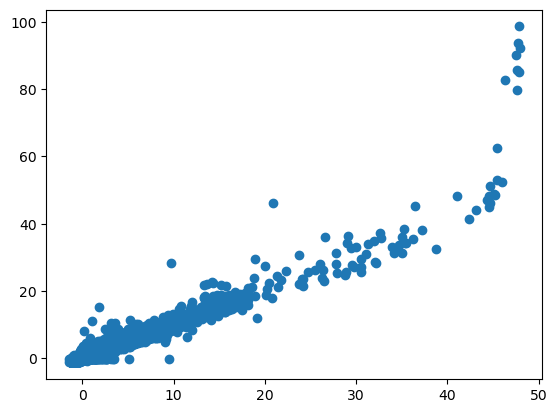

In [134]:
#plt.scatter(np.array(y_pred)[:,0],np.array(y_targ)[:,0])
#plt.plot(y_data_strat_mean[:,0])
#plt.plot(y_data_strat_std[:,0])
#print(y_data_strat_n.shape)
#h1=plt.hist(y_data_strat_n[:,:,0].flatten(),bins=np.arange(-2,5,0.1))
#print(np.corrcoef(np.array(y_pred)[:,1],np.array(y_targ)[:,1]))
print()
plt.scatter(np.array(y_pred)[:,0],np.array(y_targ)[:,0])
ind_max=np.argmax(np.array(y_targ)[:,0])


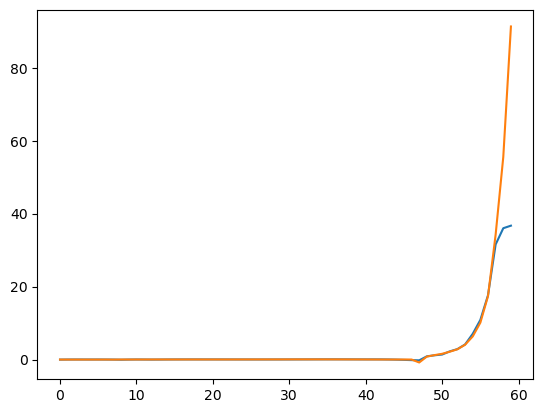

In [136]:
#print()
it=ind_max
n1=n_seq_data_strat[it]
plt.plot(outputs[it,:n1,1].detach().numpy())
plt.plot(y_data_strat_n[it,:n1,1].numpy())

In [73]:
x_data_conv_mean=torch.mean(x_data_conv,dim=0)
x_data_conv_std=torch.std(x_data_conv,dim=0)
x_data_conv_n=(x_data_conv-x_data_conv_mean)/x_data_conv_std
y_data_conv_mean=torch.mean(y_data_conv,dim=0)
y_data_conv_std=torch.std(y_data_conv,dim=0)
y_data_conv_n=(y_data_conv-y_data_conv_mean)/y_data_conv_std
conv_data=torch.utils.data.TensorDataset(x_data_conv_n,y_data_conv_n,n_seq_data_conv)
train_loader=torch.utils.data.DataLoader(conv_data,batch_size=32,shuffle=True)
# gaussian noise (3,3)
input_size=2
hidden_size=16
num_layers=2
output_size=2

model_conv=LSTMPackedModel(input_size,hidden_size,num_layers,output_size)

import torch.optim as optim
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model_conv.parameters(), lr=0.001)

In [74]:
n_epoch=20
for epoch in range(n_epoch):
    running_loss=0.0
    for i,data in enumerate(train_loader,0):
        inputs,targets,lengths=data
        optimizer.zero_grad()
        outputs=model_conv(inputs,lengths)
        n_batch,n_seq,n_feature=outputs.shape
        #print(n_batch,n_seq,n_feature)
        #print(targets.shape)
        loss=criterion(outputs,targets[:,:n_seq,:])
        mask=torch.arange(n_seq).expand(n_batch,n_seq).to(targets.device)<lengths.unsqueeze(1)
        masked_loss=loss*mask.unsqueeze(2)
        masked_loss=masked_loss.sum()/mask.sum()
        masked_loss.backward()
        optimizer.step()
        running_loss+=masked_loss.item()
    print(epoch,running_loss/len(train_loader))

0 1.4404421437156292
1 1.2228545867898128
2 1.1671211099401309
3 1.1336179273323341
4 1.1052946231835725
5 1.082608940041304
6 1.071058147911762
7 1.059022069246886
8 1.0455392377032329
9 1.0390003192640398
10 1.0307799310974526
11 1.0301206276321289
12 1.024216897643679
13 1.0197075512813698
14 1.0508290019213615
15 1.0360226634341154
16 1.0483901906055844
17 1.0092406726661272
18 1.0036680799661064
19 0.9999252845285321


In [75]:
outputs=model_conv(x_data_conv_n,n_seq_data_conv)

In [80]:
y_pred=[]
y_targ=[]
for i,output in enumerate(outputs):
    n_seq=n_seq_data_conv[i]
    y_pred.append(output[n_seq-1].detach().numpy())
    y_targ.append(y_data_conv[i,n_seq-1].numpy())

    

In [82]:
y_pred=np.array(y_pred)
y_targ=np.array(y_targ)
print(np.corrcoef(y_pred[:,0],y_targ[:,0]))
print(np.corrcoef(y_pred[:,1],y_targ[:,1]))

[[1.         0.50120339]
 [0.50120339 1.        ]]
[[1.         0.20060331]
 [0.20060331 1.        ]]


In [14]:

max_seq_len = seq_lengths.max()
mask = torch.arange(max_seq_len).expand(len(seq_lengths), max_seq_len) < seq_lengths.unsqueeze(1)
print(mask)
print(mask.unsqueeze(2).shape)
print(output.shape)
print(padded_input.shape)
print(output*mask.unsqueeze(2))
print(mask.sum())

tensor([[ True,  True,  True,  True],
        [ True,  True, False, False],
        [ True, False, False, False]])
torch.Size([3, 4, 1])
torch.Size([3, 4, 5])
torch.Size([3, 4, 10])
tensor([[[-0.1059,  0.2188,  0.1931, -0.2388, -0.1172],
         [-0.1040,  0.2339,  0.2002, -0.2660, -0.1191],
         [-0.0956,  0.2436,  0.2201, -0.2800, -0.1204],
         [-0.1036,  0.2374,  0.2176, -0.2912, -0.1312]],

        [[-0.1052,  0.2119,  0.1885, -0.2272, -0.1065],
         [-0.1137,  0.2337,  0.1941, -0.2796, -0.1234],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000]],

        [[-0.0951,  0.2130,  0.1979, -0.2385, -0.1099],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000]]],
       grad_fn=<MulBackward0>)
tensor(7)


In [25]:
range_expanded = torch.arange(max_seq_len).expand(len(seq_lengths), max_seq_len) 
print(range_expanded)
print(range_expanded<seq_lengths.unsqueeze(1))
print(seq_lengths.unsqueeze(1))
print(torch.arange(max_seq_len))
print(mask.unsqueeze(-1).shape)

tensor([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]])
tensor([[ True,  True,  True,  True],
        [ True,  True, False, False],
        [ True, False, False, False]])
tensor([[4],
        [2],
        [1]])
tensor([0, 1, 2, 3])
torch.Size([3, 4, 1])
